In [74]:
%load_ext autoreload
%autoreload 2
from copy import deepcopy
import os
os.chdir("/home/jakob/doktor/projects/EnsembleUncertainty/code")
"""Learing "logit" distribution in regression example"""
from pathlib import Path
from datetime import datetime
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch

from src.dataloaders import gaussian_sinus, one_dim_regression
import src.utils as utils
from src.distilled import niw_probability_distribution
from src.ensemble import ensemble
from src.ensemble import sep_regressor
import src.metrics as metrics

LOGGER = logging.getLogger(__name__)
EXPERIMENT_NAME = "regression_logits"

# Settings
class Args():
    pass
args = Args()
args.seed = 1
args.gpu = False
args.log_dir = Path("./logs")
args.log_level = logging.INFO
args.retrain = True

args.num_ensemble_members=10
args.num_epochs=100
args.lr = 0.01


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
def make_plots(distilled_model, data):
    test_loader = torch.utils.data.DataLoader(data,
                                              batch_size=16,
                                              shuffle=True,
                                              num_workers=0)

    predictions = np.zeros((data.n_samples, distilled_model.output_size))
    all_x = np.zeros((data.n_samples, 1))
    all_y = np.zeros((data.n_samples, 1))

    idx = 0
    for batch in test_loader:
        inputs, targets = batch

        predictions[idx * test_loader.batch_size:(idx + 1) * test_loader.batch_size, :, :] = \
            distilled_model.predict(inputs, t=None).data.numpy()

        all_x[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = inputs
        all_y[idx * test_loader.batch_size:(idx + 1) *
              test_loader.batch_size, :] = targets

        idx += 1

    plt.scatter(np.squeeze(all_x), np.squeeze(all_y), label="Data", marker=".")

    plt.errorbar(np.squeeze(all_x),
                 predictions[:, 0],
                 np.sqrt(predictions[:, 1]),
                 label="Distilled model predictions",
                 marker=".",
                 ls="none")

    plt.legend()
    plt.show()

In [76]:
log_file = Path("{}_{}.log".format(
    EXPERIMENT_NAME,
    datetime.now().strftime("%Y%m%d_%H%M%S")))
utils.setup_logger(log_path=Path.cwd() / args.log_dir / log_file,
                   log_level=args.log_level)
LOGGER.info("Args: {}".format(args))
device = utils.torch_settings(args.seed, args.gpu)
LOGGER.info("Creating dataloader")
data = gaussian_sinus.GaussianSinus(
    store_file=Path("none"))

input_size = 1
hidden_size = 10
ensemble_output_size = 2
args.num_ensemble_members = 10
args.num_epochs=50
args.lr = 0.001
args.log_level = logging.INFO
train_loader = torch.utils.data.DataLoader(data,
                                           batch_size=32,
                                           shuffle=True,
                                           num_workers=0)

prob_ensemble = ensemble.Ensemble(ensemble_output_size)
for _ in range(args.num_ensemble_members):
    model = sep_regressor.SepRegressor(input_size,
                                             hidden_size,
                                             hidden_size,
                                             ensemble_output_size,
                                             device=device,
                                             learning_rate=args.lr)
    prob_ensemble.add_member(model)
squared_error_metric = metrics.Metric(name="Squared error",
                                      function=metrics.mean_squared_error)
prob_ensemble.add_metrics([squared_error_metric])
prob_ensemble.train(train_loader, args.num_epochs)

2019-12-19 12:58:23,887 INFO  root            - Log at /home/jakob/doktor/projects/EnsembleUncertainty/code/logs/regression_logits_20191219_125823.log
2019-12-19 12:58:23,888 INFO  __main__        - Args: <__main__.Args object at 0x7fbf367a6e48>
2019-12-19 12:58:23,889 INFO  __main__        - Creating dataloader
2019-12-19 12:58:23,890 INFO  GaussianSinus   - Sampling new data
2019-12-19 12:58:24,216 INFO  SepRegressor    - Moving model to device: cpu
2019-12-19 12:58:24,217 INFO  MeanRegressor   - Moving model to device: cpu
2019-12-19 12:58:24,219 INFO  MeanRegressor   - Moving model to device: cpu
2019-12-19 12:58:24,221 WARNING Ensemble        - Is subclass check disabled
2019-12-19 12:58:24,222 INFO  Ensemble        - Adding <class 'src.ensemble.sep_regressor.SepRegressor'> to ensemble
2019-12-19 12:58:24,224 INFO  SepRegressor    - Moving model to device: cpu
2019-12-19 12:58:24,224 INFO  MeanRegressor   - Moving model to device: cpu
2019-12-19 12:58:24,227 INFO  MeanRegressor   

2019-12-19 12:58:48,606 INFO  SepRegressor    - Epoch 24: Loss: 3.7748476434499025 Squared error: 31.896644592285156
2019-12-19 12:58:49,665 INFO  SepRegressor    - Epoch 25: Loss: 2.335462348535657 Squared error: 32.22698211669922
2019-12-19 12:58:50,748 INFO  SepRegressor    - Epoch 26: Loss: 2.7484107948839664 Squared error: 32.01526641845703
2019-12-19 12:58:51,792 INFO  SepRegressor    - Epoch 27: Loss: 1.037031201645732 Squared error: 32.91291809082031
2019-12-19 12:58:52,820 INFO  SepRegressor    - Epoch 28: Loss: 0.47250289656221867 Squared error: 32.665733337402344
2019-12-19 12:58:53,834 INFO  SepRegressor    - Epoch 29: Loss: -0.42345743253827095 Squared error: 32.94770050048828
2019-12-19 12:58:54,837 INFO  SepRegressor    - Epoch 30: Loss: -0.2888512946665287 Squared error: 31.741840362548828
2019-12-19 12:58:55,870 INFO  SepRegressor    - Epoch 31: Loss: 0.37606886960566044 Squared error: 32.90134811401367
2019-12-19 12:58:56,958 INFO  SepRegressor    - Epoch 32: Loss: 1.

2019-12-19 13:00:01,422 INFO  SepRegressor    - Epoch 44: Loss: -0.9382846727967262 Squared error: 33.4999885559082
2019-12-19 13:00:02,481 INFO  SepRegressor    - Epoch 45: Loss: -0.8993887230753899 Squared error: 32.74187088012695
2019-12-19 13:00:03,542 INFO  SepRegressor    - Epoch 46: Loss: -1.0349073335528374 Squared error: 32.85524368286133
2019-12-19 13:00:04,636 INFO  SepRegressor    - Epoch 47: Loss: -0.2523271515965462 Squared error: 32.265846252441406
2019-12-19 13:00:05,685 INFO  SepRegressor    - Epoch 48: Loss: 0.15807732194662094 Squared error: 32.89625549316406
2019-12-19 13:00:06,673 INFO  SepRegressor    - Epoch 49: Loss: -1.3930206410586834 Squared error: 32.47920608520508
2019-12-19 13:00:07,681 INFO  SepRegressor    - Epoch 50: Loss: -1.4589665215462446 Squared error: 32.712425231933594
2019-12-19 13:00:07,682 INFO  Ensemble        - Training member 3/10
2019-12-19 13:00:08,679 INFO  SepRegressor    - Epoch 1: Loss: 31.49592697620392 Squared error: 18.973234176635

2019-12-19 13:01:12,130 INFO  SepRegressor    - Epoch 14: Loss: 11.257858470082283 Squared error: 29.257061004638672
2019-12-19 13:01:13,152 INFO  SepRegressor    - Epoch 15: Loss: 9.452361986041069 Squared error: 30.345853805541992
2019-12-19 13:01:14,182 INFO  SepRegressor    - Epoch 16: Loss: 7.156837148591876 Squared error: 30.636388778686523
2019-12-19 13:01:15,232 INFO  SepRegressor    - Epoch 17: Loss: 5.590030282735825 Squared error: 31.872817993164062
2019-12-19 13:01:16,264 INFO  SepRegressor    - Epoch 18: Loss: 4.470703998580575 Squared error: 31.734216690063477
2019-12-19 13:01:17,251 INFO  SepRegressor    - Epoch 19: Loss: 2.37445130571723 Squared error: 31.81374740600586
2019-12-19 13:01:18,256 INFO  SepRegressor    - Epoch 20: Loss: 4.20180157199502 Squared error: 32.84272384643555
2019-12-19 13:01:19,316 INFO  SepRegressor    - Epoch 21: Loss: 2.7637192886322737 Squared error: 32.65354919433594
2019-12-19 13:01:20,262 INFO  SepRegressor    - Epoch 22: Loss: 0.656461890

2019-12-19 13:02:23,756 INFO  SepRegressor    - Epoch 34: Loss: 0.2734261229634285 Squared error: 33.48102569580078
2019-12-19 13:02:24,744 INFO  SepRegressor    - Epoch 35: Loss: -0.13259065337479115 Squared error: 32.693607330322266
2019-12-19 13:02:25,796 INFO  SepRegressor    - Epoch 36: Loss: -0.08973374590277672 Squared error: 32.8482780456543
2019-12-19 13:02:26,844 INFO  SepRegressor    - Epoch 37: Loss: 0.24887757748365402 Squared error: 32.603797912597656
2019-12-19 13:02:27,846 INFO  SepRegressor    - Epoch 38: Loss: -1.8619019724428654 Squared error: 33.320316314697266
2019-12-19 13:02:28,883 INFO  SepRegressor    - Epoch 39: Loss: -1.5655992850661278 Squared error: 33.07853698730469
2019-12-19 13:02:29,946 INFO  SepRegressor    - Epoch 40: Loss: -0.15771855413913727 Squared error: 32.650814056396484
2019-12-19 13:02:30,899 INFO  SepRegressor    - Epoch 41: Loss: -1.3652457296848297 Squared error: 33.35867691040039
2019-12-19 13:02:31,898 INFO  SepRegressor    - Epoch 42: L

2019-12-19 13:03:35,375 INFO  SepRegressor    - Epoch 4: Loss: 33.16710662841797 Squared error: 20.90491485595703
2019-12-19 13:03:36,437 INFO  SepRegressor    - Epoch 5: Loss: 31.449875831604004 Squared error: 22.90225601196289
2019-12-19 13:03:37,600 INFO  SepRegressor    - Epoch 6: Loss: 29.73490869998932 Squared error: 24.287668228149414
2019-12-19 13:03:38,679 INFO  SepRegressor    - Epoch 7: Loss: 28.381010115146637 Squared error: 26.273277282714844
2019-12-19 13:03:39,670 INFO  SepRegressor    - Epoch 8: Loss: 27.00116890668869 Squared error: 27.28982925415039
2019-12-19 13:03:40,671 INFO  SepRegressor    - Epoch 9: Loss: 25.713467240333557 Squared error: 27.693157196044922
2019-12-19 13:03:41,712 INFO  SepRegressor    - Epoch 10: Loss: 24.489250123500824 Squared error: 28.542211532592773
2019-12-19 13:03:42,791 INFO  SepRegressor    - Epoch 11: Loss: 23.14234220981598 Squared error: 28.10463523864746
2019-12-19 13:03:43,834 INFO  SepRegressor    - Epoch 12: Loss: 22.08416342735

2019-12-19 13:04:48,739 INFO  SepRegressor    - Epoch 25: Loss: 8.84414305537939 Squared error: 30.540925979614258
2019-12-19 13:04:49,834 INFO  SepRegressor    - Epoch 26: Loss: 7.31029786542058 Squared error: 31.186677932739258
2019-12-19 13:04:50,876 INFO  SepRegressor    - Epoch 27: Loss: 6.481520541012287 Squared error: 30.86371421813965
2019-12-19 13:04:51,942 INFO  SepRegressor    - Epoch 28: Loss: 4.90839852578938 Squared error: 31.6109561920166
2019-12-19 13:04:52,937 INFO  SepRegressor    - Epoch 29: Loss: 4.048346435651183 Squared error: 31.447324752807617
2019-12-19 13:04:53,936 INFO  SepRegressor    - Epoch 30: Loss: 2.196641029790044 Squared error: 31.51421356201172
2019-12-19 13:04:55,003 INFO  SepRegressor    - Epoch 31: Loss: 1.3325677271932364 Squared error: 32.25155258178711
2019-12-19 13:04:56,015 INFO  SepRegressor    - Epoch 32: Loss: 0.9252401553094387 Squared error: 32.41059494018555
2019-12-19 13:04:57,047 INFO  SepRegressor    - Epoch 33: Loss: 0.4544674009084

2019-12-19 13:06:00,886 INFO  SepRegressor    - Epoch 46: Loss: 0.7148084528744221 Squared error: 32.763092041015625
2019-12-19 13:06:01,955 INFO  SepRegressor    - Epoch 47: Loss: -1.0496863182634115 Squared error: 32.38675308227539
2019-12-19 13:06:02,987 INFO  SepRegressor    - Epoch 48: Loss: -1.284409698098898 Squared error: 32.730594635009766
2019-12-19 13:06:04,051 INFO  SepRegressor    - Epoch 49: Loss: -1.8405605163425207 Squared error: 32.831817626953125
2019-12-19 13:06:05,130 INFO  SepRegressor    - Epoch 50: Loss: -1.5280289705842733 Squared error: 32.73649215698242
2019-12-19 13:06:05,130 INFO  Ensemble        - Training member 10/10
2019-12-19 13:06:06,165 INFO  SepRegressor    - Epoch 1: Loss: 34.74207091331482 Squared error: 19.709306716918945
2019-12-19 13:06:07,137 INFO  SepRegressor    - Epoch 2: Loss: 29.678756177425385 Squared error: 22.120288848876953
2019-12-19 13:06:08,169 INFO  SepRegressor    - Epoch 3: Loss: 27.38968539237976 Squared error: 25.3159236907959


In [8]:
start = -5
end = 5
step = 0.1
x_length = int((end - start) / step)
x = torch.arange(start=start,
                 end=end,
                 step=step).reshape((x_length, 1)).float()
output = prob_ensemble.predict(x)
x = x.detach().numpy()[:,0]


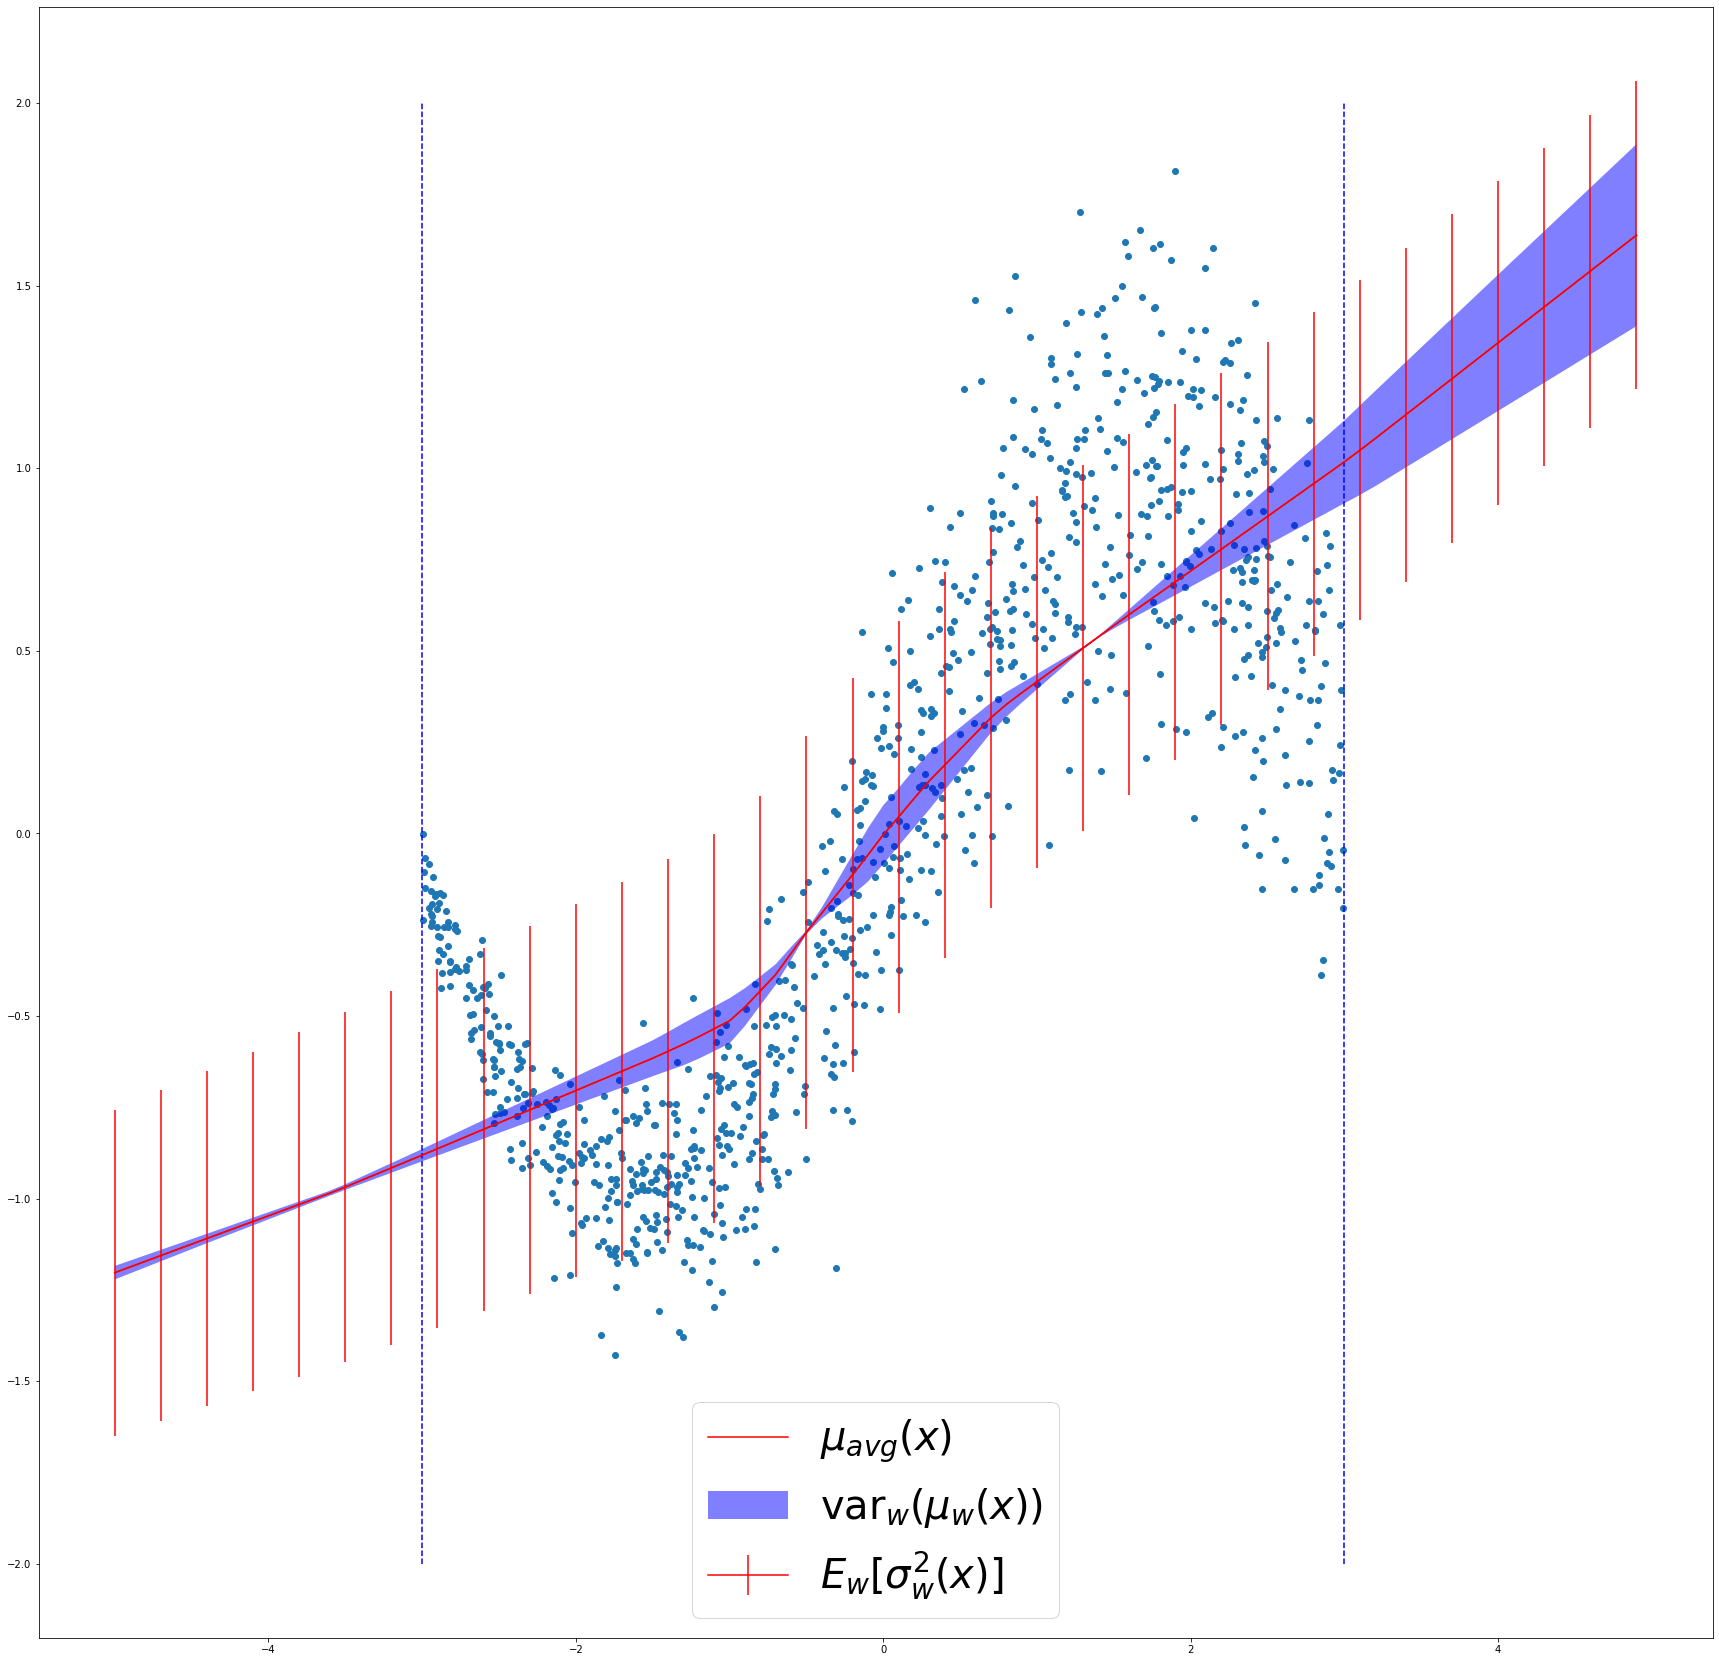

In [9]:
def plot_uncert(ax, data, x, mean_mu=None, ale=None, epi=None):
    inputs = data[:, :-1]
    targets = data[:, -1]
    ax.scatter(inputs, targets)
    lower_x_bound = np.array([-3, -3])
    upper_x_bound = np.array([3, 3])
    y_bound = np.array([-2, 2])
    ax.plot(lower_x_bound, y_bound, "b--")
    ax.plot(upper_x_bound, y_bound, "b--")
    if mean_mu is not None:
        ax.plot(x, mean_mu, "r-", label="$\mu_{avg}(x)$")
    if ale is not None:
        every_nth = 3
        ax.errorbar(x, mean_mu,
                    np.sqrt(ale),
                    errorevery=every_nth,
                    color="r",
                    label="$E_w[\sigma_w^2(x)]$")
        #ax.plot(x, ale, "g-", label="$E_w[\sigma_w^2(x)]$")
    if epi is not None:
        ax.fill_between(x, mean_mu + np.sqrt(epi), mean_mu - np.sqrt(epi),
                        facecolor = "blue", alpha=0.5, label="var$_w(\mu_w(x))$")
        #ax.plot(x, np.sqrt(100*epi))
    plt.legend(prop={'size': 40})
    plt.show()
    
mu = output[:, :, 0]
var = output[:, :, 1]
ale, epi = metrics.uncertainty_separation_parametric(mu, var)
mean_mu = torch.mean(mu, dim=1).detach().numpy()
ale = ale.detach().numpy()
epi = epi.detach().numpy()
#plot_uncert(data.get_full_data(), x, mean_mu, 10*ale, epi, ax)

plt.rcParams['figure.figsize'] = [30, 30]
_, ax = plt.subplots()

plot_uncert(ax, data.get_full_data(), x, mean_mu=mean_mu, ale=1*ale, epi=1*epi)


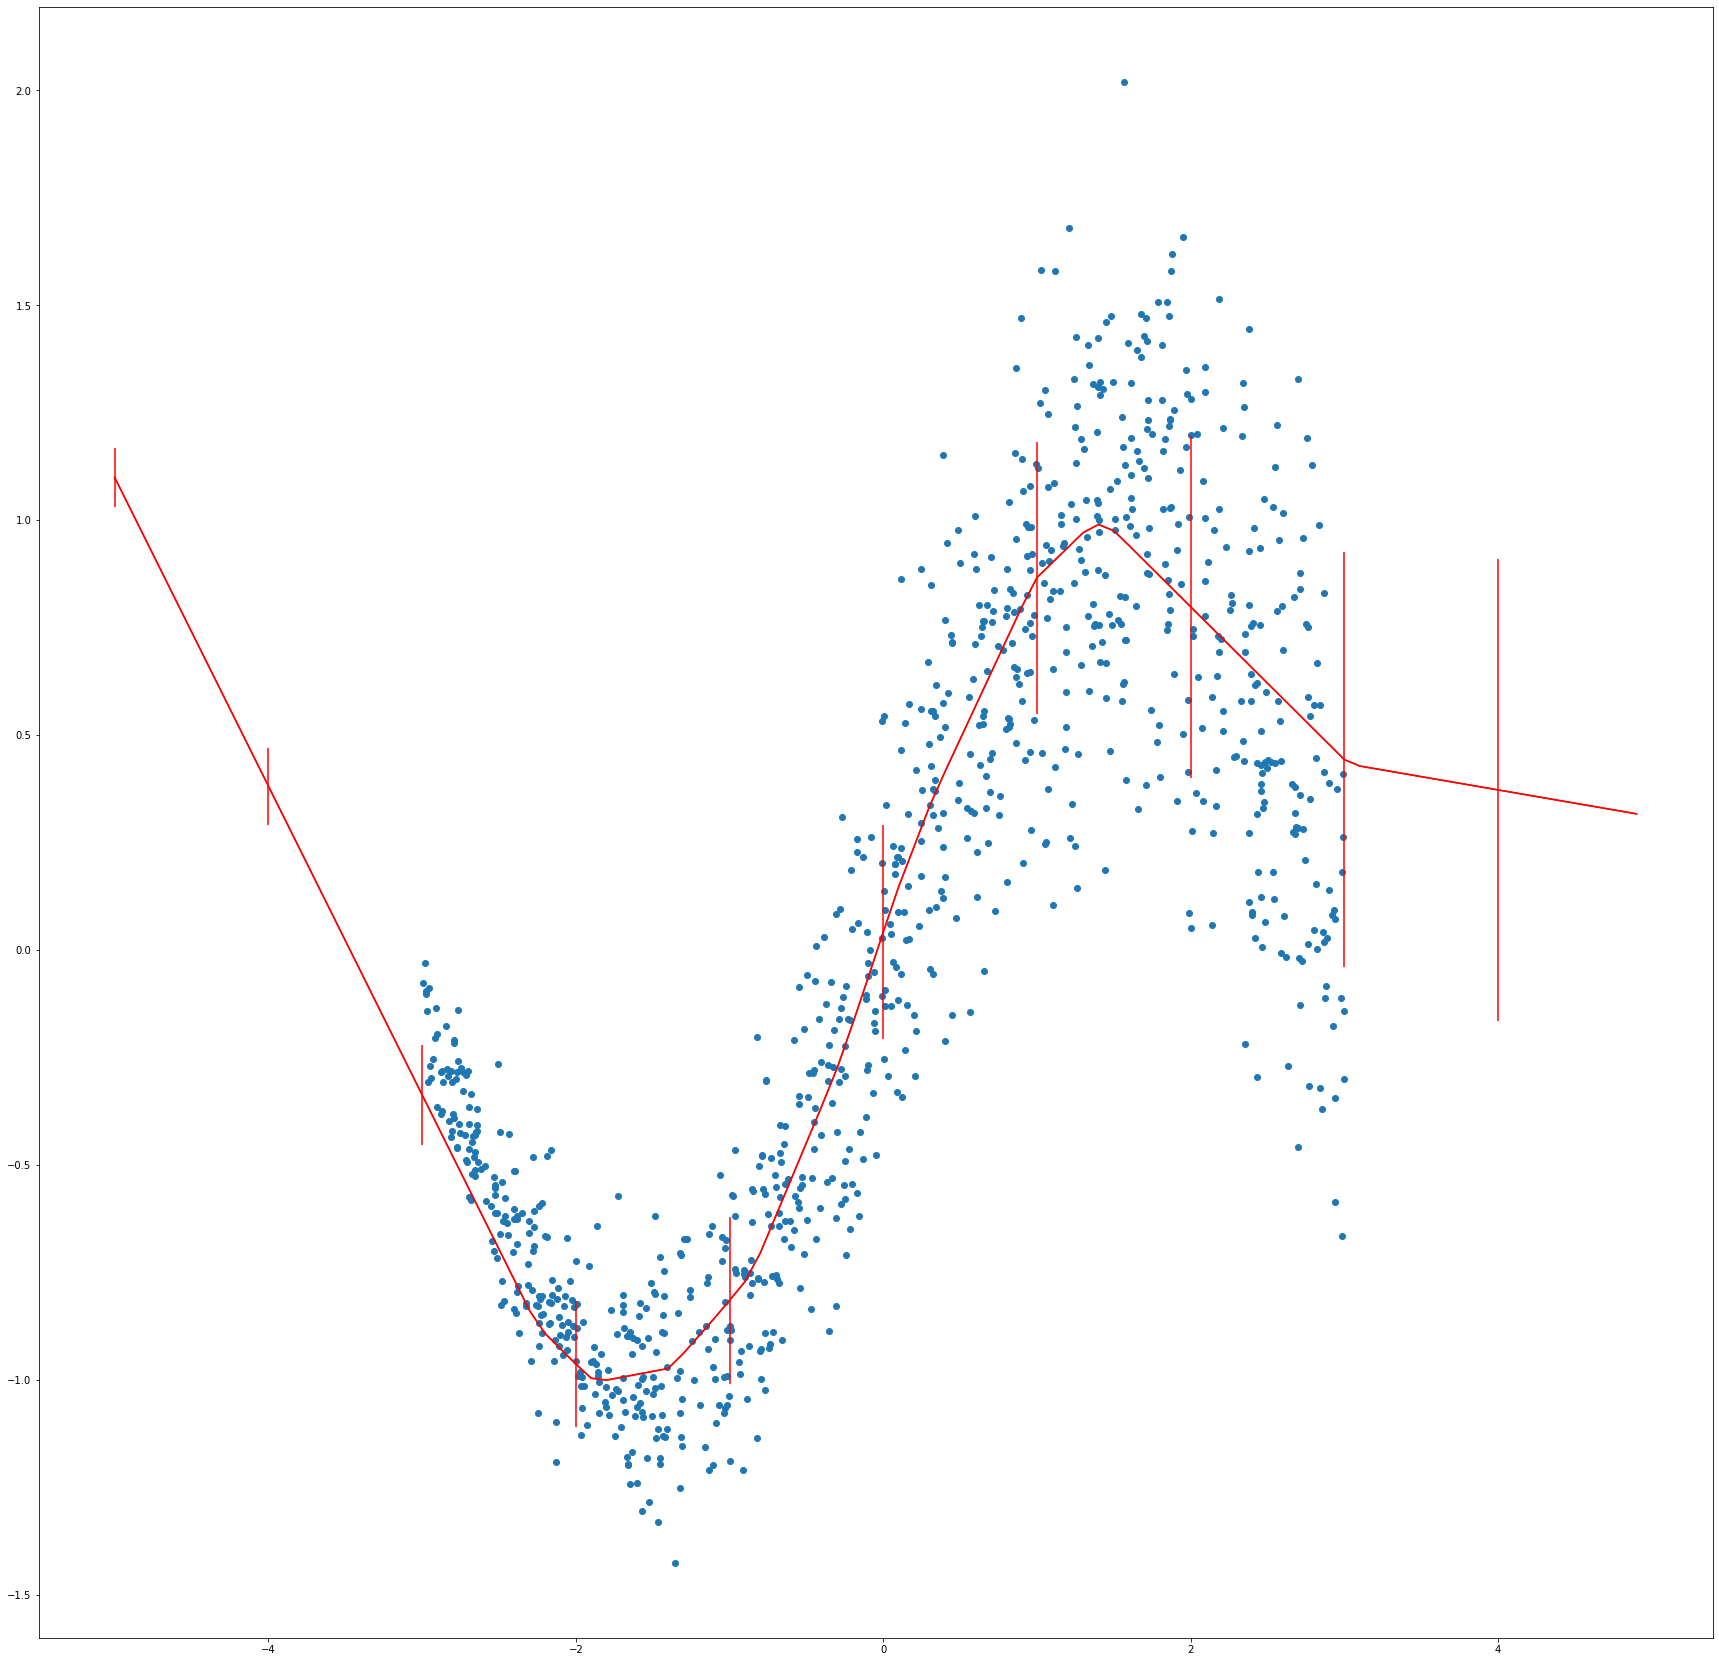

In [7]:

def plot_reg_with_pred(data, x, pred_mean, pred_var, ax):
    inputs = data[:, :-1]
    targets = data[:, -1]
    ax.scatter(inputs, targets)
    ax.plot(x, means, 'r-')
    every_nth = 10
    ax.errorbar(x, means,
                np.sqrt(var),
                errorevery=every_nth,
                color="r")
    plt.show()

plt.rcParams['figure.figsize'] = [30, 30]
member = 6
means = output.detach().numpy()[:, member, 0]
var = output.detach().numpy()[:, member, 1]
_, ax = plt.subplots()
plot_reg_with_pred(data.get_full_data(), x, means, var, ax)


In [72]:
#Create distilled!
hidden_size = 10
target_dim = 1
distilled_output_size = ensemble_output_size * 2
distilled_model = niw_probability_distribution.NiwProbabilityDistribution(
    input_size=input_size,
    hidden_size_1=hidden_size,
    hidden_size_2=hidden_size,
    target_dim=target_dim,
    output_size=distilled_output_size,
    teacher=prob_ensemble,
    device=device,
    learning_rate=args.lr)

2019-12-19 12:57:42,370 WARNING NiwProbabilityDistribution - Must assign proper loss function to child.loss.
2019-12-19 12:57:42,370 INFO  NiwProbabilityDistribution - Moving model to device: cpu


In [73]:
# Retrain!
lower = -3
upper = 3
unlabelled_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(lower, upper))
unlabelled_loader = torch.utils.data.DataLoader(unlabelled_data,
                                           batch_size=6,
                                           shuffle=True,
                                           num_workers=0)


distilled_model.train(unlabelled_loader, 50)


2019-12-19 12:57:43,803 INFO  GaussianSinus   - Sampling new data
2019-12-19 12:57:44,104 INFO  NiwProbabilityDistribution - Training distilled network.
tensor([[[0.1970],
         [0.2493]],

        [[0.2325],
         [0.2488]],

        [[0.3069],
         [0.2689]],

        [[0.2280],
         [0.2494]],

        [[0.2177],
         [0.2495]],

        [[0.2936],
         [0.2825]]])
tensor([[[0.2465],
         [0.2488]],

        [[0.2994],
         [0.1870]],

        [[0.3070],
         [0.2282]],

        [[0.2131],
         [0.2494]],

        [[0.3091],
         [0.2330]],

        [[0.3086],
         [0.2643]]])
tensor([[[0.2628],
         [0.2596]],

        [[0.2799],
         [0.2739]],

        [[0.3095],
         [0.2338]],

        [[0.2989],
         [0.1982]],

        [[0.2489],
         [0.2497]],

        [[0.3013],
         [0.2139]]])
tensor([[[0.3131],
         [0.2422]],

        [[0.3050],
         [0.2741]],

        [[0.3092],
         [0.2333]],

       

tensor([[[0.2988],
         [0.2003]],

        [[0.3047],
         [0.2750]],

        [[0.2321],
         [0.2489]],

        [[0.3077],
         [0.2667]],

        [[0.3102],
         [0.2354]],

        [[0.2232],
         [0.2495]]])
tensor([[[0.3045],
         [0.2755]],

        [[0.3156],
         [0.2518]],

        [[0.2990],
         [0.1809]],

        [[0.3125],
         [0.2564]],

        [[0.2503],
         [0.2502]],

        [[0.2992],
         [0.1826]]])
tensor([[[0.3100],
         [0.2349]],

        [[0.2701],
         [0.2666]],

        [[0.2612],
         [0.2581]],

        [[0.2937],
         [0.2825]],

        [[0.2988],
         [0.2012]],

        [[0.3038],
         [0.2209]]])
tensor([[[0.2157],
         [0.2494]],

        [[0.1901],
         [0.2493]],

        [[0.2872],
         [0.2789]],

        [[0.3112],
         [0.2379]],

        [[0.2615],
         [0.2584]],

        [[0.3020],
         [0.2159]]])
tensor([[[0.2113],
         [0.2494]],



RuntimeError: cholesky_cpu: U(1,1) is zero, singular U.

In [17]:
ens_output

tensor([[[ 1.1916e+00,  2.6066e-03],
         [ 9.9381e-02,  1.5704e-03],
         [ 2.2755e+00,  2.2816e-03],
         [ 2.0420e+00,  2.0861e-03],
         [ 3.3533e-01,  1.8998e-03],
         [ 1.3554e+00,  6.9984e-03],
         [ 1.8180e+00,  2.8036e-03],
         [ 8.7915e-01,  2.5211e-03],
         [ 9.8879e-01,  1.4928e-03],
         [-1.8933e-01,  8.0172e-04]],

        [[ 1.0856e+00,  2.9885e-03],
         [ 7.3824e-02,  1.8576e-03],
         [ 2.0778e+00,  2.6116e-03],
         [ 1.8572e+00,  2.4267e-03],
         [ 2.9376e-01,  2.2173e-03],
         [ 1.2352e+00,  7.6221e-03],
         [ 1.6384e+00,  3.1949e-03],
         [ 8.0135e-01,  2.9060e-03],
         [ 9.4840e-01,  1.7699e-03],
         [-1.8933e-01,  1.0023e-03]],

        [[ 9.7947e-01,  3.4263e-03],
         [ 4.8267e-02,  2.1972e-03],
         [ 1.8802e+00,  2.9892e-03],
         [ 1.6725e+00,  2.8226e-03],
         [ 2.5218e-01,  2.5878e-03],
         [ 1.1150e+00,  8.3010e-03],
         [ 1.4589e+00,  3.6408e-03

2019-12-19 09:07:01,261 INFO  GaussianSinus   - Sampling new data


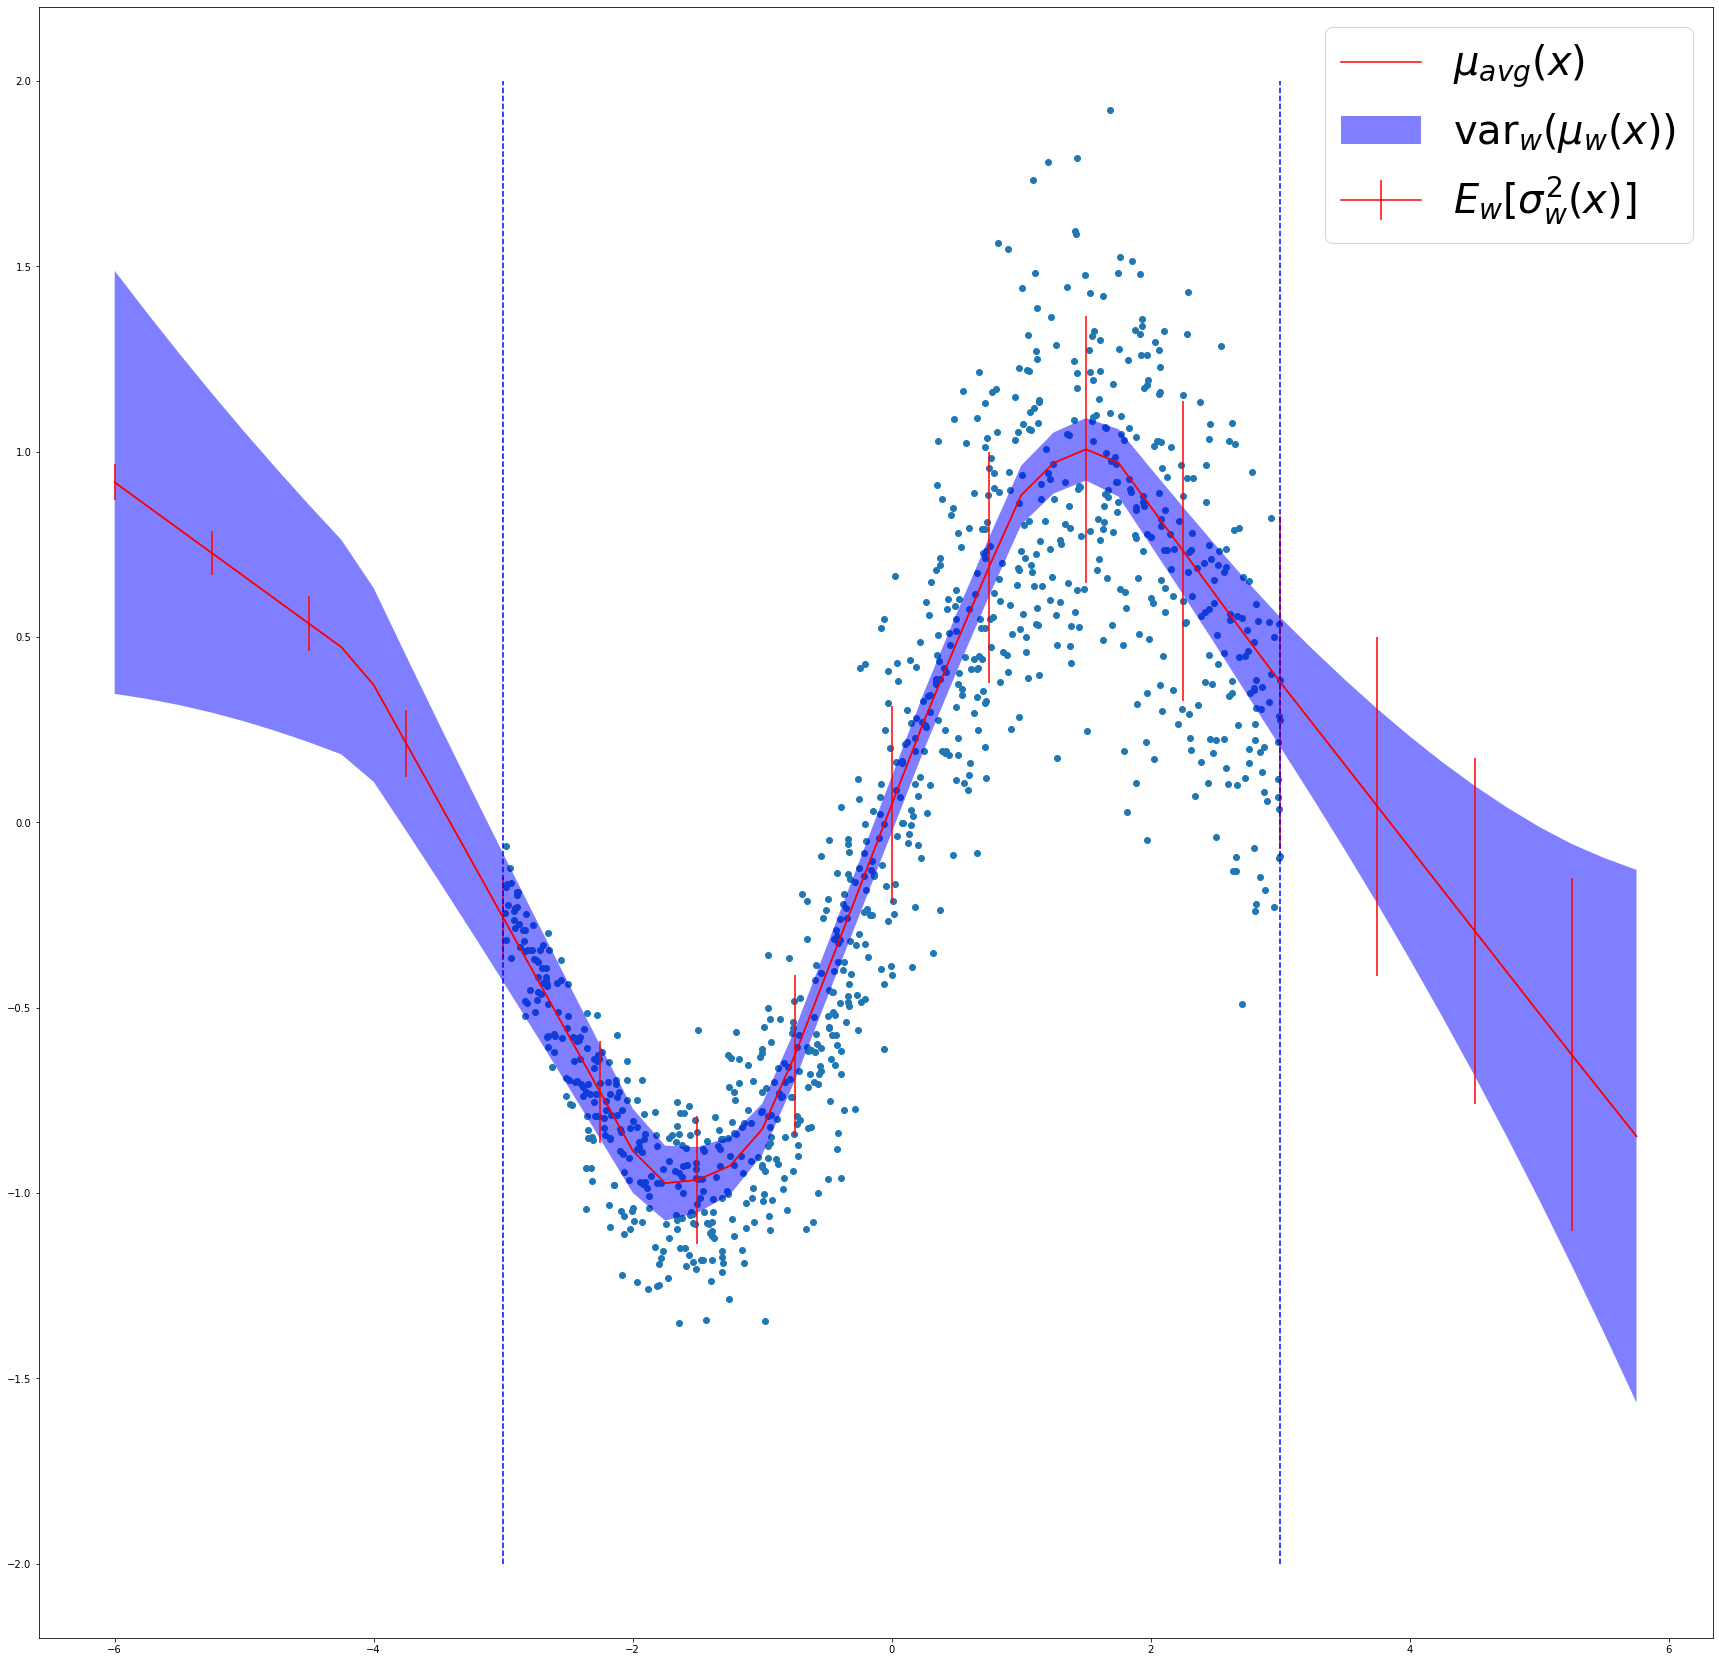

In [38]:
def plot_reg_with_pred(data, x, pred_mean, pred_var, ax):
    inputs = data[:, :-1]
    targets = data[:, -1]
    ax.scatter(inputs, targets)
    ax.plot(x, pred_mean, 'r-')
    every_nth = 10
    ax.errorbar(x, pred_mean,
                np.sqrt(pred_var),
                errorevery=every_nth,
                color="r")
    plt.show()

def plot_uncert(ax, data, x, mean_mu=None, ale=None, epi=None):
    inputs = data[:, :-1]
    targets = data[:, -1]
    ax.scatter(inputs, targets)
    lower_x_bound = np.array([-3, -3])
    upper_x_bound = np.array([3, 3])
    y_bound = np.array([-2, 2])
    ax.plot(lower_x_bound, y_bound, "b--")
    ax.plot(upper_x_bound, y_bound, "b--")
    if mean_mu is not None:
        ax.plot(x, mean_mu, "r-", label="$\mu_{avg}(x)$")
    if ale is not None:
        every_nth = 3
        ax.errorbar(x, mean_mu,
                    np.sqrt(ale),
                    errorevery=every_nth,
                    color="r",
                    label="$E_w[\sigma_w^2(x)]$")
    if epi is not None:
        ax.fill_between(x, mean_mu + np.sqrt(epi), mean_mu - np.sqrt(epi),
                        facecolor = "blue", alpha=0.5, label="var$_w(\mu_w(x))$")
        #ax.plot(x, np.sqrt(100*epi))
    plt.legend(prop={'size': 40})
    plt.show()
    
def compare_ale(ax, x, ale_ens, ale_dist):
    mu = np.sin(x)
    sigma = 0.15 * 1 / (1 + np.exp(-x))
    ax.plot(x, sigma, label="true")
    ax.plot(x, ale_ens, label="Ens")
    ax.plot(x, ale_dist, label="Dist")
    ax.legend(prop={'size': 40})
    plt.show()


start = -6
end = 6
step = 0.25
x_length = int((end - start) / step)
x = torch.arange(start=start,
                 end=end,
                 step=step, requires_grad=False).reshape((x_length, 1)).float()

ens_output = prob_ensemble.predict(x)
mu_ens = ens_output[:, :, 0]
var_ens = ens_output[:, :, 1]
ale_ens, _ = metrics.uncertainty_separation_parametric(mu_ens, var_ens)
ale_ens = ale_ens.detach().numpy()
z_mean, z_var = distilled_model.forward(x);
z_mean = z_mean.detach().numpy()
z_var = z_var.detach().numpy()
x = x.detach().numpy()[:,0]

mu = z_mean[:, 0]
ale_dist = np.log( 1 + np.exp(z_mean[:, 1]))
epi_dist = z_var[:, 1]


plt.rcParams['figure.figsize'] = [30, 30]
_, ax = plt.subplots()
#plot_reg_with_pred(data.get_full_data(), x, mu, sigma_sq, ax)

#compare_ale(ax, x, ale_ens, ale_dist)
plot_data = gaussian_sinus.GaussianSinus(
    store_file=Path("None"), train=False, range_=(-3, 3))
plot_uncert(ax, unlabelled_data.get_full_data(), x, mean_mu=mu, ale=1*ale_dist, epi=1*epi_dist)


In [95]:
from src.loss import gaussian_neg_log_likelihood
x_test = torch.tensor((3.0)).reshape((1,1))
ens_output = prob_ensemble.get_logits(x_test)
print("Ens", ens_output.shape)
print("Ens mean", ens_output.mean(1))
z_mean, z_var = distilled_model.forward(x_test)
mu = z_mean[0, :].reshape((1,2))
cov = z_var[0, :].reshape((1,2))
print("mu", mu)
print("cov", cov)
with torch.no_grad():
    loss = gaussian_neg_log_likelihood((mu, cov), ens_output)
    print(loss)

Ens torch.Size([1, 10, 2])
Ens mean tensor([[ 0.3436, -1.5226]], grad_fn=<MeanBackward1>)
mu tensor([[ 0.3782, -1.4990]], grad_fn=<AsStridedBackward>)
cov tensor([[0.0210, 0.0316]], grad_fn=<AsStridedBackward>)
tensor([[0.0210, 0.0000],
        [0.0000, 0.0316]])
torch.Size([10, 2])
tensor([ 1.5115, -0.0824,  1.6787,  1.6718, -1.1106,  1.7438,  1.3201,  0.9794,
         1.0006,  0.0298])
loss tensor(-0.8743)
tensor(-0.8743)


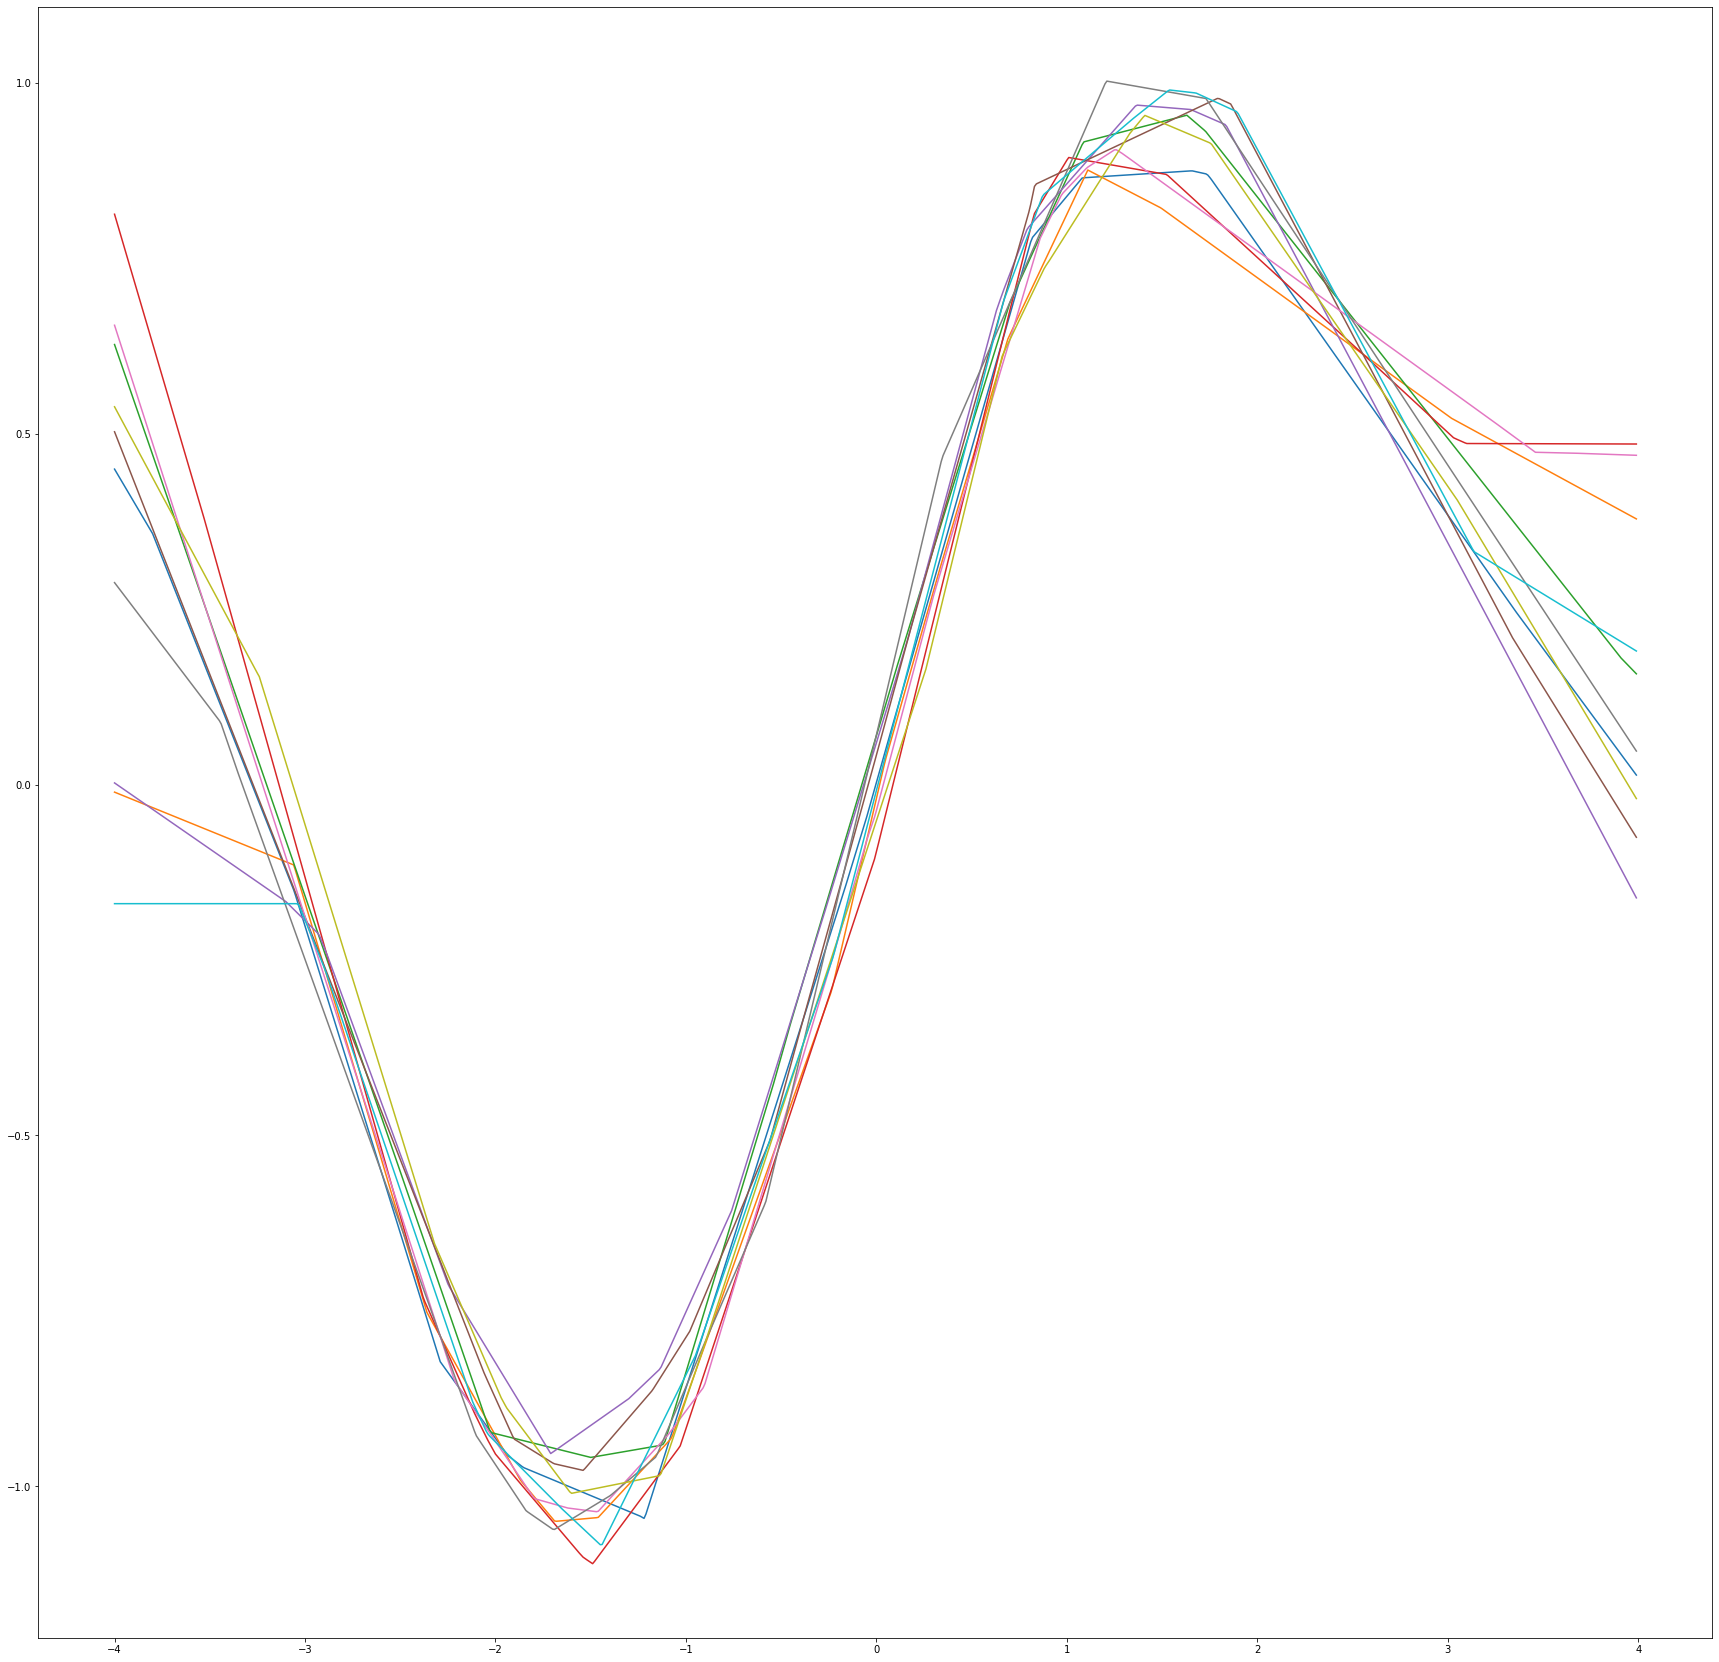

In [24]:
start = -4
end = 4
step = 0.01
x_length = int((end - start) / step)
x = torch.arange(start=start,
                 end=end,
                 step=step, requires_grad=False).reshape((x_length, 1)).float()
ensemble_preds = distilled_model._generate_teacher_predictions(x)
ensemble_preds.shape

plt.plot(x, ensemble_preds[:, :, 0].detach().numpy())


In [ ]:
cov_mat = torch.Size([1])
cov_mat = torch.eye(torch.Size([1]))
diff = torch.ones(torch.Size([2, 1]))


torch.matmul(diff, diff.T)
diff.shape